# Import everything needed from the previous experiments

In [1]:

%run busi_augmentation_2.ipynb

Found 210 images and 211 masks in malignant folder


Processing malignant masks: 100%|███████████████████████████████████████████████████| 211/211 [00:00<00:00, 597.10it/s]


Found 133 images and 133 masks in normal folder


Processing normal masks: 100%|██████████████████████████████████████████████████████| 133/133 [00:00<00:00, 299.14it/s]


Found 437 images and 454 masks in benign folder


Processing benign masks: 100%|██████████████████████████████████████████████████████| 454/454 [00:00<00:00, 617.00it/s]


Combined 2 masks for malignant (53).png
Combined 2 masks for benign (100).png
Combined 2 masks for benign (163).png
Combined 2 masks for benign (173).png
Combined 2 masks for benign (181).png
Combined 3 masks for benign (195).png
Combined 2 masks for benign (25).png
Combined 2 masks for benign (315).png
Combined 2 masks for benign (346).png
Combined 2 masks for benign (4).png
Combined 2 masks for benign (424).png
Combined 2 masks for benign (54).png
Combined 2 masks for benign (58).png
Combined 2 masks for benign (83).png
Combined 2 masks for benign (92).png
Combined 2 masks for benign (93).png
Combined 2 masks for benign (98).png
Dataset shape: (780, 224, 224, 1)
Masks shape: (780, 224, 224, 1)
Labels shape: (780,)
Class distribution: Normal: 133, Benign: 437, Malignant: 210
Training set sizes: X_train: (546, 224, 224, 1), y_train: (546,), masks: (780, 224, 224, 1)
Augmented training set sizes: X_aug: (1758, 224, 224, 1), y_aug: (1758,), masks: (1758, 224, 224, 1)
Validation set sizes

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, fbeta_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, Flatten,  Dropout, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import seaborn as sns
import time

In [3]:
print(X_aug.shape)
print(y_aug.shape)
print(masks_aug.shape)

(1758, 224, 224, 1)
(1758,)
(1758, 224, 224, 1)


## Apply normalization on the dataset

In [4]:
# Train
X_train_aug = X_aug.astype("float32") / 255.0
masks_train_aug = masks_aug.astype("float32") / 255.0
y_train_aug = y_aug

# Test
X_test = X_test.astype("float32") / 255.0
masks_test = masks_test.astype("float32") / 255.0
y_test = y_test

# Validation
X_val = X_val.astype("float32") / 255.0
masks_val = masks_val.astype("float32") / 255.0
y_val = y_val




| Term                    | Meaning                                            |
| ----------------------- | -------------------------------------------------- |
| **TP** (True Positive)  | Model predicts positive and it’s actually positive |
| **TN** (True Negative)  | Model predicts negative and it’s actually negative |
| **FP** (False Positive) | Model predicts positive but it’s actually negative |
| **FN** (False Negative) | Model predicts negative but it’s actually positive |


### Accuracy

Definition: Fraction of correct predictions among all predictions.

**Accuracy= (TP+TN) / (TP+TN+FP+FN)**

- Measures overall correctness.
- Simple, easy to interpret.
- Can be misleading with imbalanced datasets (common in medical imaging).

### Precision (a.k.a Positive Predictive Value)

Definition: Fraction of correct positive predictions among all predicted positives.

**Precision=TP / (TP+FP)**

- High precision → few false positives
- Important when FP is costly, e.g., unnecessary biopsy alerts.

### Recall (a.k.a Sensitivity or True Positive Rate)

Definition: Fraction of actual positives that were correctly predicted.

**Recall=TP / (TP+FN)**

- High recall → few false negatives
- Critical in medical diagnosis: missing a tumor (FN) is very bad.

### F1 Score

Definition: Harmonic mean of precision and recall.

**F1=2⋅Precision⋅Recall/ (Precision+Recall)**

- Balances precision and recall.
- Useful when we want a single metric but care about both FP and FN equally.

### F2 Score

Definition: Weighted harmonic mean of precision and recall, emphasizing recall more than precision.

**F(β) = (1+β^2)⋅Precision⋅Recall/ (β^2⋅Precision)+Recall**

- For F2, β = 2 → recall is weighted more.
- We can use F2 when missing positives is much worse than having false positives, e.g., detecting cancer.

## 1. Model(early stopping, adam optimizer, sparse loss)

In [5]:
# Early stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True,monitor='val_loss', verbose=1)

model_final_simple = Sequential([
        Input(shape=(224, 224, 1)),
        Conv2D(64, kernel_size=(5,5), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Conv2D(128, kernel_size=(3,3), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Conv2D(256, kernel_size=(3,3), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Flatten(),
        Dense(128, activation=(LeakyReLU(negative_slope=0.01))),
        Dropout(0.7),
        Dense(3, activation='softmax')
        ])

In [6]:
# Compile
model_final_simple.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train
model_final_simple.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop]
)
        

Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.3549 - loss: 1.2230 - val_accuracy: 0.5556 - val_loss: 1.0417
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.4562 - loss: 1.0415 - val_accuracy: 0.6068 - val_loss: 0.9061
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.5950 - loss: 0.8796 - val_accuracy: 0.5897 - val_loss: 0.7832
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.7065 - loss: 0.6940 - val_accuracy: 0.6496 - val_loss: 0.7367
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.8049 - loss: 0.4999 - val_accuracy: 0.6838 - val_loss: 0.7321
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.8561 - loss: 0.3674 - val_accuracy: 0.7179 - val_loss: 0.6321
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.8720 - loss: 0.3289 - val_accuracy: 0.7521 - val_loss: 0.6872
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9295 - loss: 0.1872 - val_accuracy: 0.7607 - val_loss

## Evaluation metrics

### Precision , recall and f1

In [10]:
# Predict probabilities
y_test_probs = model_final_simple.predict(X_test)

# convert probabilities to predicted class labels
y_test_pred = np.argmax(y_test_probs, axis=1)


# Classification Report (includes precision, recall, f1-score per class)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=4))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.8000    0.6000    0.6857        20
           1     0.7639    0.8333    0.7971        66
           2     0.7333    0.7097    0.7213        31

    accuracy                         0.7607       117
   macro avg     0.7657    0.7143    0.7347       117
weighted avg     0.7620    0.7607    0.7580       117



### F2

In [11]:
f2_score = fbeta_score(y_test, y_test_pred, beta=2, average='weighted')
print("F2-score:", round(f2_score, 4))

F2-score: 0.7589


### Heatmap confusion matrix

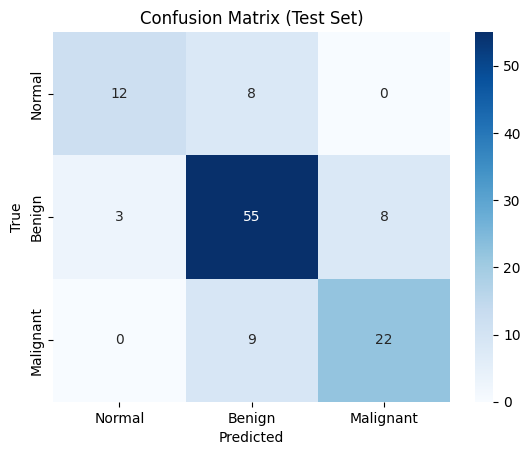

In [12]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Benign', 'Malignant'], yticklabels=['Normal', 'Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()

## 2. Model(early stopping, adam optimizer, sparse loss,  ReduceLROnPlateau with aggressive decay parameters)

In [14]:
# Early stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True,monitor='val_loss', verbose=1)

model_final_aggr_decay = Sequential([
        Input(shape=(224, 224, 1)),
        Conv2D(64, kernel_size=(5,5), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Conv2D(128, kernel_size=(3,3), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Conv2D(256, kernel_size=(3,3), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Flatten(),
        Dense(128, activation=(LeakyReLU(negative_slope=0.01))),
        Dropout(0.7),
        Dense(3, activation='softmax')
        ])

# Compile your model
model_final_aggr_decay.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
reduce_lr_2 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# Train with callbacks
history = model_final_aggr_decay.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, reduce_lr_2]
)

Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.3623 - loss: 1.3834 - val_accuracy: 0.5641 - val_loss: 1.0733 - learning_rate: 0.0010
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.3811 - loss: 1.0898 - val_accuracy: 0.5299 - val_loss: 1.0239 - learning_rate: 0.0010
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.4465 - loss: 1.0535 - val_accuracy: 0.5812 - val_loss: 0.9345 - learning_rate: 0.0010
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.4693 - loss: 1.0168 - val_accuracy: 0.5556 - val_loss: 0.9559 - learning_rate: 0.0010
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5301 - loss: 0.9543
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
55/55 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.5455 - loss: 0.9505 - val_accuracy: 0.4103 - val_loss: 0.9944 - learning_rate: 0.0010
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.6223 - loss: 0.8183 - val_accuracy: 0

In [16]:
# Predict probabilities
y_test_probs = model_final_aggr_decay.predict(X_test)

# convert probabilities to predicted class labels
y_test_pred = np.argmax(y_test_probs, axis=1)


# Classification Report (includes precision, recall, f1-score per class)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=4))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.7500    0.3000    0.4286        20
           1     0.7191    0.9697    0.8258        66
           2     0.9500    0.6129    0.7451        31

    accuracy                         0.7607       117
   macro avg     0.8064    0.6275    0.6665       117
weighted avg     0.7856    0.7607    0.7365       117



In [17]:
f2_score = fbeta_score(y_test, y_test_pred, beta=2, average='weighted')
print("F2-score:", round(f2_score, 4))

F2-score: 0.7444


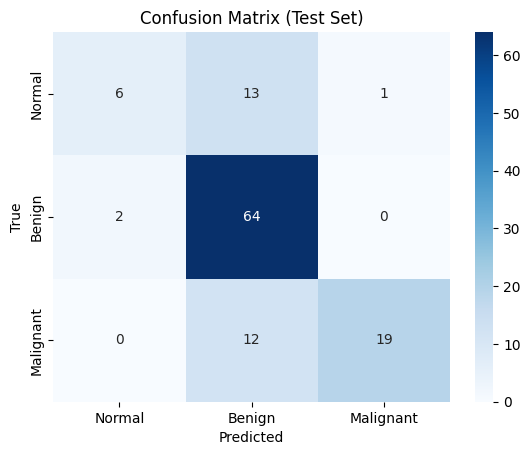

In [18]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Benign', 'Malignant'], yticklabels=['Normal', 'Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()

Strengths of Model 2:

Very high recall for class 1 (malignant?): 96.97% (vs. 83.33% in Model 1)

High precision for class 2 (normal?): 95.00% (vs. 73.33%)

Weaknesses of Model 2:

Terrible recall for class 0 (benign?): 30.00% (vs. 60.00%)

Only 6/20 benign cases correctly classified

Lower F2-score overall: 0.7444 (vs. 0.7589)

Macro F1 is significantly worse (0.6665 vs. 0.7347), meaning model 2 is less balanced across classes

So *model 1 is the best, for now*.

## 3. Model(early stopping, CosineDecay optimizer (normal steps), sparse loss)

In [20]:
# Early stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True,monitor='val_loss', verbose=1)

model_final_cos_1 = Sequential([
        Input(shape=(224, 224, 1)),
        Conv2D(64, kernel_size=(5,5), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Conv2D(128, kernel_size=(3,3), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Conv2D(256, kernel_size=(3,3), activation=(LeakyReLU(negative_slope=0.01))),
        MaxPooling2D(pool_size=(2, 2)),
    
        Flatten(),
        Dense(128, activation=(LeakyReLU(negative_slope=0.01))),
        Dropout(0.7),
        Dense(3, activation='softmax')
        ])


In [21]:
lr_schedule_1 = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=30 * len(X_train_aug),  # for 30 epochs
    alpha=1e-5
)

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule_1)

# Compile 
model_final_cos_1.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
 
# Train
history = model_final_cos_1.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.3561 - loss: 1.1655 - val_accuracy: 0.2222 - val_loss: 1.0924
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.4824 - loss: 1.0247 - val_accuracy: 0.5299 - val_loss: 0.9913
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.5683 - loss: 0.9084 - val_accuracy: 0.5726 - val_loss: 0.8365
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.6576 - loss: 0.7822 - val_accuracy: 0.7009 - val_loss: 0.7664
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.7730 - loss: 0.5684 - val_accuracy: 0.7265 - val_loss: 0.6896
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8350 - loss: 0.4241 - val_accuracy: 0.7265 - val_loss: 0.6726
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8959 - loss: 0.2688 - val_accuracy: 0.7607 - val_loss: 0.7102
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9147 - loss: 0.2150 - val_accuracy: 0.7521 - val_loss:

In [25]:
# Predict probabilities
y_test_probs = model_final_cos_1.predict(X_test)

# convert probabilities to predicted class labels
y_test_pred = np.argmax(y_test_probs, axis=1)


# Classification Report (includes precision, recall, f1-score per class)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=4))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.6842    0.6500    0.6667        20
           1     0.7945    0.8788    0.8345        66
           2     0.8400    0.6774    0.7500        31

    accuracy                         0.7863       117
   macro avg     0.7729    0.7354    0.7504       117
weighted avg     0.7877    0.7863    0.7834       117



In [26]:
f2_score = fbeta_score(y_test, y_test_pred, beta=2, average='weighted')
print("F2-score:", round(f2_score, 4))

F2-score: 0.7844


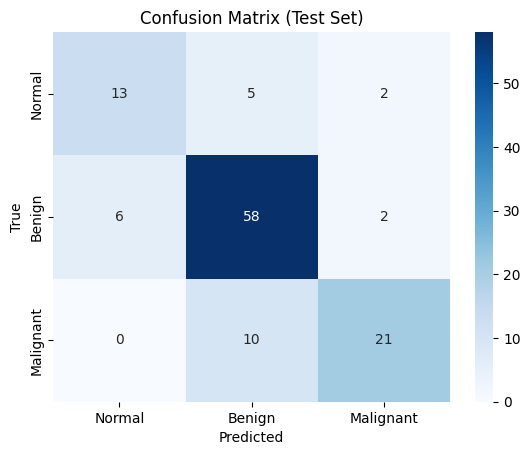

In [27]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Benign', 'Malignant'], yticklabels=['Normal', 'Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()

So this model has the best performance on the test set. It reached an accuracy of 78.63%, a weighted F1-score of 0.7834, and a weighted F2-score of 0.7844, the highest until now. The F2-score, which emphasizes recall, is particularly important in breast cancer detection, where minimizing false negatives is critical. The model showed strong recall for the malignant class (87.88%), indicating reliable identification of potentially cancerous lesions. At the same time, maintained balanced performance across all the three classes, with satisfactory precision and recall for both benign and normal cases. The confusion matrix showes fewer major misclassifications compared to earlier models. Given its superior F2-score and consistent per-class performance, this model was selected as the best-performing classifier in the study.

## 4. Model(early stopping, CosineDecay optimizer (longer steps), sparse loss)

We shall not evaluate this model, because it is exactly as Model 3, but with 40 steps (epochs) instead of 30. For keeping fairness between the models, we will remain with the first 3 models, as they all have 30 epochs.